In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
import cython
%load_ext Cython

In [3]:
%%cython -a
#cython: boundscheck=False, wraparound=False, initializedcheck=False, nonecheck=False, cdivision=True
import cython
import numpy as np
cimport numpy as np
np.import_array()

from libc.math cimport round, sqrt


DOUBLE = np.float64
ctypedef np.float64_t DOUBLE_t
INTEGER = np.int32


cdef class LJBox:
    cdef double epsilon, sigma        # Parameters of LJ Potential
    cdef double r_cut, r_cut2         # Cutoff distance
    cdef double e_cut                 # Energy Shift due to truncation
    cdef double r_skin, r_skin2       # Skin distance for neighbour list
    cdef int n_part, n_dim            # Number of particles and dimensions
    cdef double[:] box_shape          # Shape of the cuboid boundary (Periodic Boundary)
    
    cdef double[:] rij                # Workspace to store r_j - r_i
    # Neighbour list Data
    cdef int[:] list_near
    cdef int[:] iarr_part
    # To determine when to update
    cdef double[:, ::1] del_r
    
    # Logging
    cdef int n_update
    
    def __init__(self, double epsilon, double sigma,
                 double r_cut, double r_skin,
                 int n_dim, double[:] box_shape, int n_part):
        self.epsilon, self.sigma = epsilon, sigma
        self.r_cut, self.r_skin = r_cut, r_skin
        self.r_cut2 = self.r_cut * self.r_cut
        self.r_skin2 = self.r_skin * self.r_skin
        
        self.n_dim, self.n_part = n_dim, n_part
        self.box_shape = np.array(box_shape, dtype=DOUBLE)
        
        self.n_update = 0
        
        self.rij = np.zeros(n_dim, dtype=DOUBLE)
        
        self.list_near = np.zeros((n_part - 1) * n_part / 2, dtype=INTEGER)
        self.iarr_part = np.zeros(n_part, dtype=INTEGER)
        self.del_r = np.zeros((n_part, n_dim), dtype=DOUBLE)
        
        cdef double r2, r6
        r2 = self.r_cut2 / (sigma * sigma)
        r6 = r2 * r2 * r2
        self.e_cut = 4 * epsilon * (1 / (r6 * r6) - 1 / r6)
    
    # Routine to check if neighbour list needs to be update based of displacement during previous step
    cdef void check_neighbours(self, double[:, ::1] pos_t, double[:, ::1] pos_t):
        cdef int iarr, i_part, j_part, i_dim
        cdef double dr2, delta
        
        # Updating total displacement since last update of the neighbour list
        for i_part in range(self.n_part):
            for i_dim in range(self.n_dim):
                self.del_r += pos_n[i_part, i_dim] - pos_t[i_part, i_dim]
        
        # Determining the two largest distance 
        cdef double delta, dr1, dr2
        dr1, dr2 = 0, 0
        for i_part in range(self.n_part):
            delta = 0
            for i_dim in range(self.n_dim):
                delta += self.del_r[i_part, i_dim] * self.del_r[i_part, i_dim]
            if delta > dr1:
                dr2 = dr1
                dr1 = delta
            elif delta > dr2:
                dr2 = delta
        dr1, dr2 = sqrt(dr1), sqrt(dr2)
        
        # If the sum of largest two displacement is greater than skin thickness,
        # Update neighbour list
        if dr1 + dr2 > self.r_skin - self.r_cut: 
            self.update_neighbours(pos_t)
    
    # Updating neighbour list
    cdef void update_neighbours(self, double[:, ::1] pos):
        # Resetting quantities
        self.del_r[...] = 0
        self.list_near[...] = 0
        self.iarr_part[...] = 0
        
        cdef int i_part, j_part, i_dim, iarr
        cdef double dr2, delta
        
        iarr = 0 # Where in self.list_near is the particle index stored
        for i_part in range(self.n_part - 1): 
            self.iarr_part[i_part] = iarr # Where in self.list_near is does the sublist of particle indices start
            for j_part in range(i_part + 1, self.n_part):
                dr2 = 0
                for i_dim in range(self.n_dim):
                    delta = pos[j_part, i_dim] - pos[i_part, i_dim]
                    # Applying periodic boundary conditions
                    delta -= self.box_shape[i_dim] * round(delta / self.box_shape[i_dim])
                    
                    dr2 += delta * delta
                
                if dr2 < self.r_skin2:
                    self.list_near[iarr] = j_part
                    iarr += 1
    
    # Calculate force and potential
    cpdef double compute_force_en(self, double[:] rij, double[:] fi, double[:] fj):
        cdef double r2, r6, r12, fac
        cdef int i_dim
        
        r2 = 0
        for i_dim in range(self.n_dim):
            r2 += rij[i_dim] * rij[i_dim]
        
        if r2 > self.r_cut2:
            return 0
        r2 /= self.sigma * self.sigma
        
        r6 = r2 * r2 * r2
        r12 = r6 * r6
        fac = 48 * (1 / r12 - 0.5 / r6) / r2

        fac *= self.epsilon / self.sigma
        
        for i_dim in range(self.n_dim):
            fi[i_dim] -= fac * rij[i_dim]
            fj[i_dim] += fac * rij[i_dim]
        
        fac = 4 * (1 / r12 - 1 / r6)
        fac *= self.epsilon

        return fac - self.e_cut
        
    cdef double compute(self, double[:, ::1] pos, double[:, ::1] force):
        cdef int i_part, j_part, i_dim, iarr
        cdef double delta, dr, dr1, dr2
        cdef double e_pot

        e_pot = 0
        
        dr1, dr2 = 0, 0
        for i_part in range(self.n_part):
            dr = 0
            for i_dim in range(self.n_dim):
                delta = pos[i_part, i_dim] - self.pos_start[i_part, i_dim]
                dr += delta * delta
            dr = sqrt(dr)
            if dr > dr1:
                dr2 = dr1
                dr1 = dr
            elif dr > dr2:
                dr2 = dr
        
        if dr1 + dr2 >= self.r_skin - self.r_cut:
            self.compute_neighbours(pos)
        
        for i_part in range(self.n_part - 1):
            for iarr in range(self.iarr_part[i_part], self.iarr_part[i_part + 1]):
                j_part = self.list_near[iarr]
                
                for i_dim in range(self.n_dim):
                    delta = pos[j_part, i_dim] - pos[i_part, i_dim]
                    self.rij[i_dim] = delta - self.box_shape[i_dim] * round(delta / self.box_shape[i_dim])
                
                e_pot += self.compute_force_en(self.rij, force[i_part, :],
                                              force[j_part, :])
        
        return e_pot


cdef class IntVerletLJ:
    cdef double del_t
    cdef int n_part, n_dim
    cdef double[:, ::1] force
    cdef double[:] box_shape
    cdef LJBox lj
    
    def __init__(self, int n_part, int n_dim, double[:] box_shape,
                 double del_t, LJBox lj):
        self.n_part, self.n_dim = n_part, n_dim
        self.box_shape = box_shape
        self.del_t = del_t
        self.lj = lj
        
        self.force = np.zeros((n_part, n_dim), dtype=DOUBLE)
        
    cdef double compute_force(self, double[:, ::1] pos):
        cdef double e_pot = 0
        self.force[...] = 0
        
        e_pot += self.lj.compute(pos, self.force)
        
        return e_pot
        
    def step(self, double[:] mass, double[:, ::1] pos_t, double[:, ::1] vel_t,
             double[:, ::1] pos_n, double[:, ::1] vel_n):
        cdef double e_pot, e_kin
        
        e_pot, e_kin = 0, 0
        
        self.compute_force(pos_t)
        
        for i_part in range(self.n_part):
            for i_dim in range(self.n_dim):
                vel_n[i_part, i_dim] = vel_t[i_part, i_dim] \
                                     + 0.5 * self.del_t * self.force[i_part, i_dim] / mass[i_part]
                pos_n[i_part, i_dim] = pos_t[i_part, i_dim] + self.del_t * vel_n[i_part, i_dim]
                
                pos_n[i_part, i_dim] = pos_n[i_part, i_dim] % self.box_shape[i_dim]
                if pos_n[i_part, i_dim] < 0:
                    pos_n[i_part, i_dim] += self.box_shape[i_dim]
        
        e_pot = self.compute_force(pos_n)
        
        for i_part in range(self.n_part):
            for i_dim in range(self.n_dim):
                vel_n[i_part, i_dim] += 0.5 * self.del_t * self.force[i_part, i_dim] / mass[i_part]
                e_kin += 0.5 * mass[i_part] * vel_n[i_part, i_dim] * vel_n[i_part, i_dim]
        
        return e_pot, e_kin
        
        

In [10]:
epsilon, sigma, m = 1, 1, 1
r_cut = 4 * sigma

n_dim = 3
n_part = 864

rho = 0.1 * sigma**3
del_t = 0.002 * np.sqrt(epsilon / (m * sigma**2))
n_step = 1000
T = 6.0 * epsilon

mass = np.ones(n_part, dtype=np.float64) * m
a = np.cbrt(np.sum(mass) / rho)
print(a)
box_shape = np.ones(n_dim, dtype=np.float64) * a

pos = np.zeros((n_step+1, n_part, n_dim), dtype = np.float64)
vel = np.zeros((n_step+1, n_part, n_dim), dtype = np.float64)
ke = np.zeros(n_step+1, dtype=np.float64)
pe = np.zeros(n_step+1, dtype=np.float64)


pos[0], vel[0] = initialize_pos_vel(mass, box_shape, T)

lj = LJBox(epsilon, sigma, r_cut, n_dim, box_shape, n_part)
verlet = IntVerletLJ(n_part, n_dim, del_t, lj)


20.519711360120365
10


In [11]:
i = 0
%prun ke[i+1], pe[i+1] = verlet.step(mass, pos[i], vel[i], pos[i+1], vel[i+1])

         745661 function calls in 0.246 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.202    0.101    0.246    0.123 _cython_magic_64cb76557e1b5aecb5a016152c57ac81.pyx:63(compute)
   745632    0.044    0.000    0.044    0.000 _cython_magic_64cb76557e1b5aecb5a016152c57ac81.pyx:36(compute_force_en)
        1    0.000    0.000    0.246    0.246 <string>:1(<module>)
        1    0.000    0.000    0.246    0.246 _cython_magic_64cb76557e1b5aecb5a016152c57ac81.pyx:110(step)
        1    0.000    0.000    0.246    0.246 {built-in method builtins.exec}
        2    0.000    0.000    0.246    0.123 _cython_magic_64cb76557e1b5aecb5a016152c57ac81.pyx:102(compute_force)
        1    0.000    0.000    0.246    0.246 {method 'step' of '_cython_magic_64cb76557e1b5aecb5a016152c57ac81.IntVerletLJ' objects}
        5    0.000    0.000    0.000    0.000 stringsource:657(memoryview_cwrapper)
        5    0.000    0.000    0.000

In [12]:
%%time
for i in range(n_step):
    print('{:d} / {:d}; {:f}, {:f} {:f}'.format(i, n_step,
                                                ke[i], pe[i], ke[i] + pe[i]), end='\r')
    ke[i+1], pe[i+1] = verlet.step(mass, pos[i], vel[i], pos[i+1], vel[i+1])
print('done')

done/ 1000; -361.926384, 24039.849115 23677.922731
CPU times: user 2min 13s, sys: 273 ms, total: 2min 13s
Wall time: 2min 13s


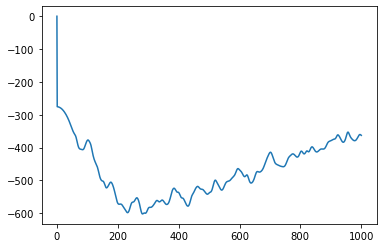

In [13]:
fig = plt.figure()
plt.plot(ke)
plt.show()